# Regressão Linear Múltipla com MQO (Mínimos Quadrados Ordinários)

### Importando Bibliotecas Necessárias

In [1]:
from ucimlrepo import fetch_ucirepo
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import QuantileTransformer

from trabalho_ic_aplicada.models.aux import plot_disperssao_hist_residuo


2025-07-17 08:00:59.771 | INFO     | trabalho_ic_aplicada.config:<module>:11 - PROJ_ROOT path is: /home/apo-pc/Documents/Github/Trabalhos_IC_Aplicada


In [2]:
# Modulos personalizados, com modelos de regressão linear e funções auxiliares

import trabalho_ic_aplicada.models.ridge_reg_linear_MQO as reglin
import trabalho_ic_aplicada.models.aux as aux

### Importando o Dataset

In [3]:
# fetch dataset
real_estate_valuation = fetch_ucirepo(id=477)

features = real_estate_valuation.variables.iloc[1:, 0].values
# data (as pandas dataframes)
X = real_estate_valuation.data.features.to_numpy()

# Removendo a primeira coluna (X1 transaction date) que não é um atributo relevante, segundo analise.
# X = X[:, 1:]

y = real_estate_valuation.data.targets.to_numpy().ravel()

### Divisão dos Dados em Conjuntos de Treinamento e Teste

In [4]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [5]:
k_fold = aux.validacao_cruzada_kfold(X,y,k=10)


## Treinamento do Modelo de Regressão Linear com Regularização L2 (Ridge


O melhor caso acontece quando uso a normalização Interquartil. Quando as outras normalizações ajudam a não criar valores muito altos para os coeficientes, apesar de não melhorar o desempenho. NO entanto, a normalização Interquatil (robusta) melhora o desempenho em todas as metricas, superando o artigo.



### Validação Cruzada K-Fold

#### Sem Normalização dos Dados

In [6]:
%%time

eqms = []
reqms = []
r_quadrados = []
hit_rates_20 = []
hit_rates_10 = []

for k in range(len(k_fold)):
    X_train_k = X[k_fold[k][0], :]
    y_train_k = y[k_fold[k][0]]

    # Treinamento do modelo de regressão linear com regularização L2
    b_h = reglin.treinar_reglin_l2(X_train_k, y_train_k, lambda_reg=0.01)

    X_test_k = X[k_fold[k][1], :]
    y_test_k = y[k_fold[k][1]]

    # Previsão nos dados de teste
    y_pred_k = reglin.prever(b_h, X_test_k)

    # Avaliação do modelo
    eqm = np.mean((y_test_k - y_pred_k) ** 2)
    reqm = np.sqrt(eqm)
    r_quadrado = 1 - (np.sum((y_test_k - y_pred_k) ** 2) / np.sum((y_test - np.mean(y_test_k)) ** 2))
    hit_rate_20 = aux.error_rit_rate(y_test_k, y_pred_k, 0.20)
    hit_rate_10 = aux.error_rit_rate(y_test_k, y_pred_k, 0.10)

    eqms.append(eqm)
    reqms.append(reqm)
    r_quadrados.append(r_quadrado)
    hit_rates_20.append(hit_rate_20)
    hit_rates_10.append(hit_rate_10)

print(f"Erro Quadrático Médio (EQM): {np.mean(eqms):.4f} ± {np.std(eqms):.4f}")
print(f"Raiz do Erro Quadrático Médio (REQM): {np.mean(reqms):.4f} ± {np.std(reqms):.4f}")
print(f"Coeficiente de Determinação (R²): {np.mean(r_quadrados):.4f} ± {np.std(r_quadrados):.4f}")
print(f"Hit rate 20%: {np.mean(hit_rates_20):.4f} ± {np.std(hit_rates_20):.4f}")
print(f"Hit rate 10%: {np.mean(hit_rates_10):.4f} ± {np.std(hit_rates_10):.4f}\n")

print(f"Intercepto (b[0]): {b_h[0]:.4f}")
for i in range(0, len(b_h)):
    print(f"Atributo: {features[i]} | b[{i}]: {b_h[i]:.4f}")

Erro Quadrático Médio (EQM): 80.8615 ± 41.7267
Raiz do Erro Quadrático Médio (REQM): 8.7419 ± 2.1075
Coeficiente de Determinação (R²): 0.7496 ± 0.1290
Hit rate 20%: 0.6831 ± 0.0691
Hit rate 10%: 0.4005 ± 0.0967

Intercepto (b[0]): -2.0634
Atributo: X1 transaction date | b[0]: -2.0634
Atributo: X2 house age | b[1]: 4.1714
Atributo: X3 distance to the nearest MRT station | b[2]: -0.2680
Atributo: X4 number of convenience stores | b[3]: -0.0058
Atributo: X5 latitude | b[4]: 1.2071
Atributo: X6 longitude | b[5]: 142.0070
Atributo: Y house price of unit area | b[6]: -97.8944
CPU times: user 1.28 ms, sys: 1.01 ms, total: 2.29 ms
Wall time: 1.92 ms


#### Z-Score

In [7]:

%%time
eqms_z = []
reqms_z = []
r_quadrados_z = []
hit_rates_20_z = []
hit_rates_10_z = []

from sklearn.preprocessing import StandardScaler


for k in range(len(k_fold)):
    X_train_k_z = X[k_fold[k][0], :]
    y_train_k = y[k_fold[k][0]]

    # Normalização dos dados usando Z-Score
    scaler = StandardScaler()
    X_train_k_z = scaler.fit_transform(X_train_k_z)

    # Treinamento do modelo de regressão linear com regularização L2
    b_h_z = reglin.treinar_reglin_l2(X_train_k_z, y_train_k, lambda_reg=0.01)

    X_test_k_z = X[k_fold[k][1], :]
    # Normalização dos dados de teste usando Z-Score
    X_test_k_z = scaler.transform(X_test_k_z)

    y_test_k = y[k_fold[k][1]]

    # Previsão nos dados de teste
    y_pred_k_z = reglin.prever(b_h_z, X_test_k_z)

    # Avaliação do modelo
    eqm = np.mean((y_test_k - y_pred_k_z) ** 2)
    reqm = np.sqrt(eqm)
    r_quadrado = 1 - (np.sum((y_test_k - y_pred_k_z) ** 2) / np.sum((y_test - np.mean(y_test_k)) ** 2))
    hit_rate_20 = aux.error_rit_rate(y_test_k, y_pred_k_z, 0.20)
    hit_rate_10 = aux.error_rit_rate(y_test_k, y_pred_k_z, 0.10)

    eqms_z.append(eqm)
    reqms_z.append(reqm)
    r_quadrados_z.append(r_quadrado)
    hit_rates_20_z.append(hit_rate_20)
    hit_rates_10_z.append(hit_rate_10)

print(f"Erro Quadrático Médio (EQM): {np.mean(eqms_z):.4f} ± {np.std(eqms_z):.4f}")
print(f"Raiz do Erro Quadrático Médio (REQM): {np.mean(reqms_z):.4f} ± {np.std(reqms_z):.4f}")
print(f"Coeficiente de Determinação (R²): {np.mean(r_quadrados_z):.4f} ± {np.std(r_quadrados_z):.4f}")
print(f"Hit rate 20%: {np.mean(hit_rates_20_z):.4f} ± {np.std(hit_rates_20_z):.4f}")
print(f"Hit rate 10%: {np.mean(hit_rates_10_z):.4f} ± {np.std(hit_rates_10_z):.4f}\n")

print(f"Intercepto (b[0]): {b_h_z[0]:.4f}")
for i in range(0, len(b_h_z)):
    print(f"Atributo: {features[i]} | b[{i}]: {b_h_z[i]:.4f}")


Erro Quadrático Médio (EQM): 80.0510 ± 42.9357
Raiz do Erro Quadrático Médio (REQM): 8.6829 ± 2.1582
Coeficiente de Determinação (R²): 0.7523 ± 0.1328
Hit rate 20%: 0.6997 ± 0.0642
Hit rate 10%: 0.3886 ± 0.0987

Intercepto (b[0]): 37.8515
Atributo: X1 transaction date | b[0]: 37.8515
Atributo: X2 house age | b[1]: 1.5240
Atributo: X3 distance to the nearest MRT station | b[2]: -3.1060
Atributo: X4 number of convenience stores | b[3]: -5.8427
Atributo: X5 latitude | b[4]: 3.4331
Atributo: X6 longitude | b[5]: 2.5591
Atributo: Y house price of unit area | b[6]: -0.4380
CPU times: user 6.76 ms, sys: 0 ns, total: 6.76 ms
Wall time: 6.22 ms


#### Min-Max

In [8]:
%%time

eqms_mm = []
reqms_mm = []
r_quadrados_mm = []
hit_rates_20_mm = []
hit_rates_10_mm = []

from sklearn.preprocessing import MinMaxScaler

for k in range(len(k_fold)):
    X_train_k_mm = X[k_fold[k][0], :]
    y_train_k = y[k_fold[k][0]]

    # Normalização dos dados usando Min-Max
    scaler_mm = MinMaxScaler()
    X_train_k_mm = scaler_mm.fit_transform(X_train_k_mm)

    # Treinamento do modelo de regressão linear com regularização L2
    b_h_mm = reglin.treinar_reglin_l2(X_train_k_mm, y_train_k, lambda_reg=0.01)

    X_test_k_mm = X[k_fold[k][1], :]
    # Normalização dos dados de teste usando Min-Max
    X_test_k_mm = scaler_mm.transform(X_test_k_mm)

    y_test_k = y[k_fold[k][1]]

    # Previsão nos dados de teste
    y_pred_k_mm = reglin.prever(b_h_mm, X_test_k_mm)

    # Avaliação do modelo
    eqm = np.mean((y_test_k - y_pred_k_mm) ** 2)
    reqm = np.sqrt(eqm)
    r_quadrado = 1 - (np.sum((y_test_k - y_pred_k_mm) ** 2) / np.sum((y_test - np.mean(y_test_k)) ** 2))
    hit_rate_20 = aux.error_rit_rate(y_test_k, y_pred_k_mm, 0.20)
    hit_rate_10 = aux.error_rit_rate(y_test_k, y_pred_k_mm, 0.10)

    eqms_mm.append(eqm)
    reqms_mm.append(reqm)
    r_quadrados_mm.append(r_quadrado)
    hit_rates_20_mm.append(hit_rate_20)
    hit_rates_10_mm.append(hit_rate_10)

print(f"Erro Quadrático Médio (EQM): {np.mean(eqms_mm):.4f} ± {np.std(eqms_mm):.4f}")
print(f"Raiz do Erro Quadrático Médio (REQM): {np.mean(reqms_mm):.4f} ± {np.std(reqms_mm):.4f}")
print(f"Coeficiente de Determinação (R²): {np.mean(r_quadrados_mm):.4f} ± {np.std(r_quadrados_mm):.4f}")
print(f"Hit rate 20%: {np.mean(hit_rates_20_mm):.4f} ± {np.std(hit_rates_20_mm):.4f}")
print(f"Hit rate 10%: {np.mean(hit_rates_10_mm):.4f} ± {np.std(hit_rates_10_mm):.4f}\n")

print(f"Intercepto (b[0]): {b_h_mm[0]:.4f}")
for i in range(0, len(b_h_mm)):
    print(f"Atributo: {features[i]} | b[{i}]: {b_h_mm[i]:.4f}")


Erro Quadrático Médio (EQM): 80.0455 ± 42.9601
Raiz do Erro Quadrático Médio (REQM): 8.6824 ± 2.1590
Coeficiente de Determinação (R²): 0.7523 ± 0.1328
Hit rate 20%: 0.6997 ± 0.0642
Hit rate 10%: 0.3910 ± 0.0984

Intercepto (b[0]): 33.9762
Atributo: X1 transaction date | b[0]: 33.9762
Atributo: X2 house age | b[1]: 4.9902
Atributo: X3 distance to the nearest MRT station | b[2]: -11.9053
Atributo: X4 number of convenience stores | b[3]: -30.3601
Atributo: X5 latitude | b[4]: 11.8748
Atributo: X6 longitude | b[5]: 14.5844
Atributo: Y house price of unit area | b[6]: -2.3730
CPU times: user 5.56 ms, sys: 976 μs, total: 6.53 ms
Wall time: 5.94 ms


#### Interquartil

In [9]:
%%time
eqms_iqr = []
reqms_iqr = []
r_quadrados_iqr = []
hit_rates_20_iqr = []
hit_rates_10_iqr = []

for k in range(len(k_fold)):
    X_train_k_iqr = X[k_fold[k][0], :]
    y_train_k = y[k_fold[k][0]]

    # Normalização dos dados usando Interquartil
    scaler_iqr = QuantileTransformer(n_quantiles=X_train_k_iqr.shape[0],output_distribution='uniform')
    X_train_k_iqr = scaler_iqr.fit_transform(X_train_k_iqr)

    # Treinamento do modelo de regressão linear com regularização L2
    b_h_iqr = reglin.treinar_reglin_l2(X_train_k_iqr, y_train_k, lambda_reg=0.01)

    X_test_k_iqr = X[k_fold[k][1], :]
    # Normalização dos dados de teste usando Interquartil
    X_test_k_iqr = scaler_iqr.transform(X_test_k_iqr)

    y_test_k = y[k_fold[k][1]]

    # Previsão nos dados de teste
    y_pred_k_iqr = reglin.prever(b_h_iqr, X_test_k_iqr)

    # Avaliação do modelo
    eqm = np.mean((y_test_k - y_pred_k_iqr) ** 2)
    reqm = np.sqrt(eqm)
    r_quadrado = 1 - (np.sum((y_test_k - y_pred_k_iqr) ** 2) / np.sum((y_test - np.mean(y_test_k)) ** 2))
    hit_rate_20 = aux.error_rit_rate(y_test_k, y_pred_k_iqr, 0.20)
    hit_rate_10 = aux.error_rit_rate(y_test_k, y_pred_k_iqr, 0.10)

    eqms_iqr.append(eqm)
    reqms_iqr.append(reqm)
    r_quadrados_iqr.append(r_quadrado)
    hit_rates_20_iqr.append(hit_rate_20)
    hit_rates_10_iqr.append(hit_rate_10)

print(f"Erro Quadrático Médio (EQM): {np.mean(eqms_iqr):.4f} ± {np.std(eqms_iqr):.4f}")
print(f"Raiz do Erro Quadrático Médio (REQM): {np.mean(reqms_iqr):.4f} ± {np.std(reqms_iqr):.4f}")
print(f"Coeficiente de Determinação (R²): {np.mean(r_quadrados_iqr):.4f} ± {np.std(r_quadrados_iqr):.4f}")
print(f"Hit rate 20%: {np.mean(hit_rates_20_iqr):.4f} ± {np.std(hit_rates_20_iqr):.4f}")
print(f"Hit rate 10%: {np.mean(hit_rates_10_iqr):.4f} ± {np.std(hit_rates_10_iqr):.4f}\n")

print(f"Intercepto (b[0]): {b_h_iqr[0]:.4f}")
for i in range(0, len(b_h_iqr)):
    print(f"Atributo: {features[i]} | b[{i}]: {b_h_iqr[i]:.4f}")

Erro Quadrático Médio (EQM): 61.6006 ± 34.3834
Raiz do Erro Quadrático Médio (REQM): 7.5995 ± 1.9616
Coeficiente de Determinação (R²): 0.8093 ± 0.1062
Hit rate 20%: 0.7855 ± 0.0651
Hit rate 10%: 0.4640 ± 0.0746

Intercepto (b[0]): 43.2842
Atributo: X1 transaction date | b[0]: 43.2842
Atributo: X2 house age | b[1]: 6.4106
Atributo: X3 distance to the nearest MRT station | b[2]: -9.9089
Atributo: X4 number of convenience stores | b[3]: -25.3221
Atributo: X5 latitude | b[4]: 3.1751
Atributo: X6 longitude | b[5]: 13.3726
Atributo: Y house price of unit area | b[6]: 1.4861
CPU times: user 27.1 ms, sys: 929 μs, total: 28.1 ms
Wall time: 27.3 ms


# --- Seção 4: Avaliação e Visualização ---

Erro Quadrático Médio (EQM): 61.6006 ± 34.3834
Raiz do Erro Quadrático Médio (REQM): 7.5995 ± 1.9616
Coeficiente de Determinação (R²): 0.6713 ± 0.0772
Hit rate 20%: 0.7855 ± 0.0651
Hit rate 10%: 0.4640 ± 0.0746



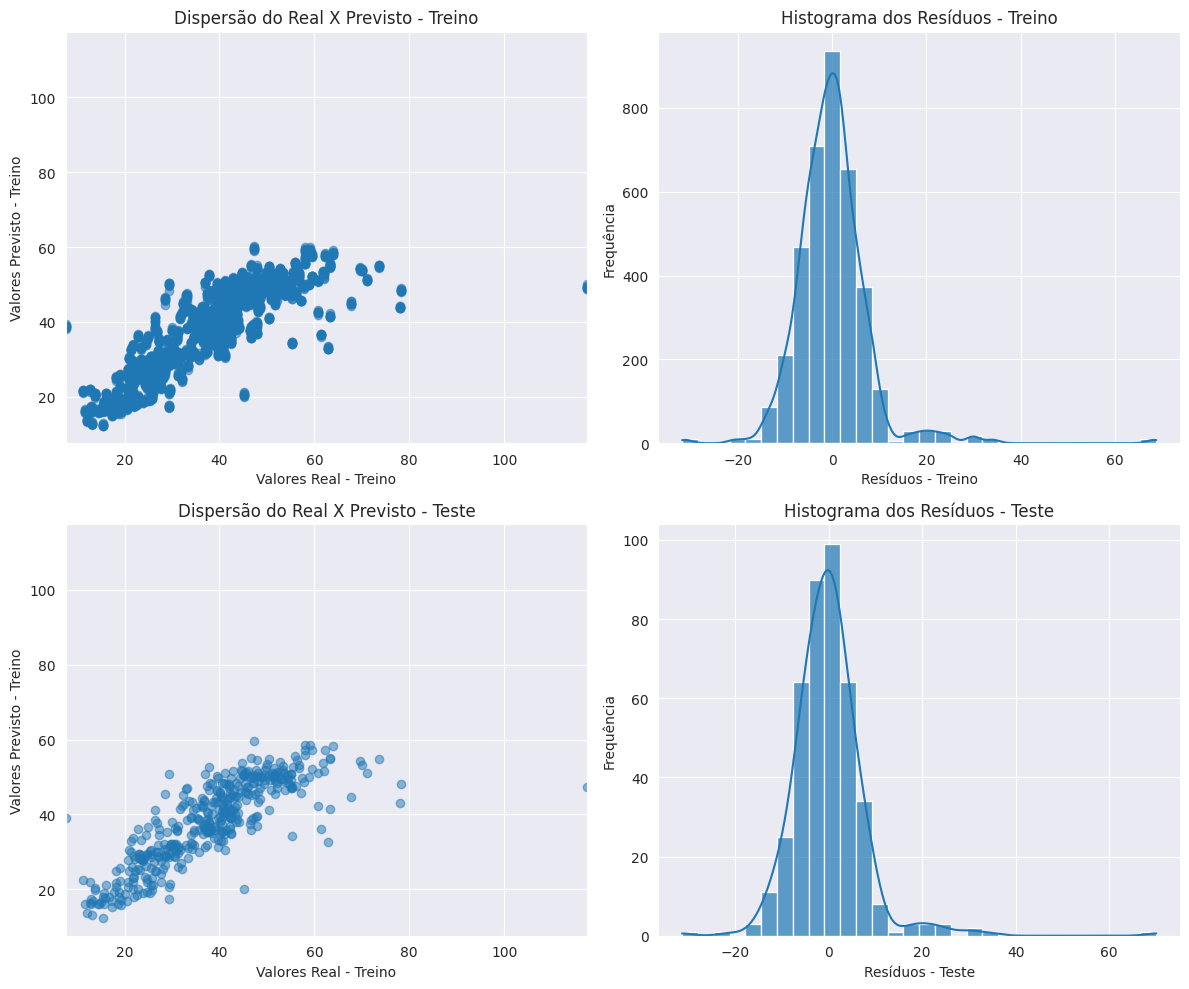


--- Análise de Gaussianidade dos Resíduos ---
Teste de Shapiro-Wilk (Treino): Estatística=0.8504, p-valor=0.0000
Teste de Shapiro-Wilk (Teste): Estatística=0.8487, p-valor=0.0000
Os resíduos de treino não seguem uma distribuição normal (p-valor < 0.05).


In [10]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

# Assumindo que 'reglin', 'aux', 'X', 'y', 'k_fold' e 'features' já estão definidos

# --- INÍCIO: Adicionar listas para armazenar os resíduos ---
y_trains = []
y_train_preds = []
y_tests = []
y_test_preds = []
# --- FIM: Adicionar listas ---

# Métricas de avaliação
eqms_iqr = []
reqms_iqr = []
r_quadrados_iqr = []
hit_rates_20_iqr = []
hit_rates_10_iqr = []

for k in range(len(k_fold)):
    X_train_k_iqr = X[k_fold[k][0], :]
    y_train_k = y[k_fold[k][0]]

    # Normalização dos dados usando QuantileTransformer (simulando robustez)
    # Nota: QuantileTransformer com output_distribution='normal' seria mais direto para o teste de normalidade.
    scaler_iqr = QuantileTransformer(n_quantiles=X_train_k_iqr.shape[0], output_distribution='uniform')
    X_train_k_iqr = scaler_iqr.fit_transform(X_train_k_iqr)

    # Treinamento do modelo
    b_h_iqr = reglin.treinar_reglin_l2(X_train_k_iqr, y_train_k, lambda_reg=0.01)

    # --- INÍCIO: Calcular e armazenar resíduos de TREINO ---
    y_pred_train_k = reglin.prever(b_h_iqr, X_train_k_iqr)
    residuos_treino = y_train_k - y_pred_train_k
    # todos_residuos_treino.extend(residuos_treino)
    # --- FIM: Calcular e armazenar resíduos de TREINO ---

    # Preparação dos dados de teste
    X_test_k_iqr = X[k_fold[k][1], :]
    X_test_k_iqr = scaler_iqr.transform(X_test_k_iqr)
    y_test_k = y[k_fold[k][1]]

    # Previsão e armazenamento dos resíduos de TESTE
    y_pred_k_iqr = reglin.prever(b_h_iqr, X_test_k_iqr)
    residuos_teste = y_test_k - y_pred_k_iqr
    # todos_residuos_teste.extend(residuos_teste)


    y_trains.extend(y_train_k)
    y_train_preds.extend(y_pred_train_k)
    y_tests.extend(y_test_k)
    y_test_preds.extend(y_pred_k_iqr)


    # Avaliação do modelo
    eqm = np.mean(residuos_teste ** 2)
    reqm = np.sqrt(eqm)
    r_quadrado = 1 - (np.sum(residuos_teste ** 2) / np.sum((y_test_k - np.mean(y_test_k)) ** 2))
    hit_rate_20 = aux.error_rit_rate(y_test_k, y_pred_k_iqr, 0.20)
    hit_rate_10 = aux.error_rit_rate(y_test_k, y_pred_k_iqr, 0.10)

    eqms_iqr.append(eqm)
    reqms_iqr.append(reqm)
    r_quadrados_iqr.append(r_quadrado)
    hit_rates_20_iqr.append(hit_rate_20)
    hit_rates_10_iqr.append(hit_rate_10)

# Impressão das métricas consolidadas (seu código original)
print(f"Erro Quadrático Médio (EQM): {np.mean(eqms_iqr):.4f} ± {np.std(eqms_iqr):.4f}")
print(f"Raiz do Erro Quadrático Médio (REQM): {np.mean(reqms_iqr):.4f} ± {np.std(reqms_iqr):.4f}")
print(f"Coeficiente de Determinação (R²): {np.mean(r_quadrados_iqr):.4f} ± {np.std(r_quadrados_iqr):.4f}")
print(f"Hit rate 20%: {np.mean(hit_rates_20_iqr):.4f} ± {np.std(hit_rates_20_iqr):.4f}")
print(f"Hit rate 10%: {np.mean(hit_rates_10_iqr):.4f} ± {np.std(hit_rates_10_iqr):.4f}\n")

# --- INÍCIO: Visualização e Análise dos Resíduos ---

# y_trains = [np.array(y_trains[i]) for i in range(len(y_trains))]

y_trains = np.array(y_trains)
y_train_preds = np.array(y_train_preds)
y_tests = np.array(y_tests)
y_test_preds = np.array(y_test_preds)

aux.plot_disperssao_hist_residuo(y_trains, y_train_preds, y_tests, y_test_preds,'Regressão Linear Múltipla com MQO (Mínimos Quadrados Ordinários)')


todos_residuos_treino = y_trains - y_train_preds
todos_residuos_teste = y_tests - y_test_preds

# Análise quantitativa da normalidade (Exemplo com teste de Shapiro-Wilk)
shapiro_treino = stats.shapiro(todos_residuos_treino)
shapiro_teste = stats.shapiro(todos_residuos_teste)

print("\n--- Análise de Gaussianidade dos Resíduos ---")
print(f"Teste de Shapiro-Wilk (Treino): Estatística={shapiro_treino.statistic:.4f}, p-valor={shapiro_treino.pvalue:.4f}")
print(f"Teste de Shapiro-Wilk (Teste): Estatística={shapiro_teste.statistic:.4f}, p-valor={shapiro_teste.pvalue:.4f}")

if shapiro_treino.pvalue < 0.05:
    print("Os resíduos de treino não seguem uma distribuição normal (p-valor < 0.05).")
else:
    print("Os resíduos de treino seguem uma distribuição normal (p-valor >= 0.05).")

### O Que Significa o Teste de Shapiro-Wilk?

O teste de Shapiro-Wilk é um teste de hipótese formal para verificar a normalidade de uma amostra de dados. A lógica por trás dele é a seguinte:

1.  **Hipótese Nula ($H_0$):** O teste parte da premissa de que a sua amostra de dados (no seu caso, os resíduos do modelo) foi extraída de uma população com distribuição normal.
2.  **p-valor:** O p-valor representa a probabilidade de se obter uma amostra tão ou mais distante da normalidade quanto a sua, **assumindo que a hipótese nula ($H_0$) seja verdadeira**.
3.  **Regra de Decisão:** Compara-se o p-valor com um nível de significância, $\alpha$ (geralmente 0.05).
    * Se `p-valor > α`, não há evidência estatística para rejeitar a hipótese nula. Concluímos que os dados podem ser considerados normais.
    * Se `p-valor < α`, a probabilidade de obter tal amostra de uma população normal é muito baixa. Portanto, **rejeitamos a hipótese nula**.

### Aplicando ao Seu Resultado

No seu caso, tanto para os resíduos de treino quanto para os de teste, o resultado foi: `p-valor=0.0000`.

* **Conclusão Estatística:** Como $0.0000 < 0.05$, você tem uma forte evidência estatística para **rejeitar a hipótese nula**. Isso significa que a distribuição dos erros do seu modelo de regressão linear **não é Gaussiana**.

### Implicações para o seu Projeto (O "E daí?")

Este resultado é mais do que um detalhe estatístico; é um diagnóstico sobre a adequação do seu modelo. [cite_start]O modelo de regressão linear por Mínimos Quadrados Ordinários (MQO) baseia-se em certas premissas para que suas inferências sejam totalmente válidas, e uma delas é a normalidade dos erros ($\epsilon_i \sim N(0, \sigma^2_\epsilon)$)[cite: 2780, 6710]. A violação dessa premissa, indicada pelo seu teste, sugere alguns cenários:

1.  **Não-Linearidade Não Capturada:** Esta é a implicação mais provável. [cite_start]O modelo de regressão linear, por definição, ajusta um hiperplano aos dados[cite: 6685]. Se a relação verdadeira entre as características (idade da casa, distância do metrô, etc.) e o preço do imóvel for intrinsecamente não-linear, o modelo linear será incapaz de capturá-la. Os resíduos (o que "sobra" depois do ajuste do modelo) conterão essa estrutura não-linear, e sua distribuição não será normal.

2.  **Presença de Outliers:** Alguns imóveis com características ou preços muito atípicos (outliers) podem estar gerando erros de previsão muito grandes. Esses erros extremos "esticam" as caudas da distribuição de resíduos, fazendo com que ela falhe no teste de normalidade.

3.  **Heterocedasticidade:** A variância dos erros pode não ser constante em toda a faixa de previsões (uma outra premissa do MQO). Por exemplo, o modelo pode ter erros muito maiores para imóveis caros do que para imóveis baratos.

### Próximos Passos e Argumentos para seu Trabalho

Este resultado é, na verdade, um excelente ponto de partida para justificar o restante do seu trabalho.

* **Justificativa para Modelos Complexos:** Você agora tem uma prova estatística de que o modelo linear simples não é suficiente para descrever completamente a complexidade dos dados. [cite_start]Este é um argumento poderoso para justificar a necessidade de investigar modelos mais flexíveis, como o **Perceptron de Múltiplas Camadas (MLP)**, que é o objetivo principal do seu trabalho[cite: 4244]. [cite_start]A capacidade das MLPs de aproximar funções não-lineares arbitrárias [cite: 6595-6596, 5138] é exatamente o que se precisa para lidar com a situação que seus resíduos estão indicando.

* **Análise Visual:** Volte ao histograma que você gerou. A não-normalidade se manifesta como uma forte assimetria (*skewness*)? Ou talvez como caudas pesadas (*heavy tails*), indicando a presença de outliers? Descrever essa forma visualmente enriquecerá sua análise.

* **Transformação da Variável-Alvo:** Em problemas de regressão com valores monetários (como preços de imóveis), é muito comum que a distribuição seja assimétrica. Uma estratégia clássica para lidar com isso é aplicar uma **transformação logarítmica** na variável de saída (`y`). Tente treinar seu modelo para prever `log(y)` em vez de `y` e refaça a análise dos resíduos. É muito provável que eles se tornem mais próximos de uma distribuição normal.


Excelentes perguntas, que demonstram uma análise crítica dos seus resultados e da metodologia. Vamos abordar cada um dos seus pontos de forma estruturada.

Primeiramente, sua correção é fundamental: o gráfico mostra **Valores Reais (Eixo X) vs. Valores Previstos (Eixo Y)**. Esta é a visualização correta para avaliar o desempenho de um modelo de regressão.

### 1. Interpretação do Gráfico de Dispersão (Real vs. Previsto)

Esta visualização é uma das ferramentas mais poderosas para diagnosticar a performance de um modelo de regressão.

#### Comportamento de um Modelo com Bom Ajuste (*Good Fit*)

* **A Reta Ideal:** Em um cenário perfeito, todos os pontos do gráfico estariam sobre a linha de identidade, ou seja, a reta $y=x$ (uma diagonal de 45 graus que parte da origem). Isso significaria que, para cada amostra, o `Valor Previsto` é exatamente igual ao `Valor Real`.
* **Na Prática:** Um bom modelo apresentará os pontos **fortemente agrupados e distribuídos de forma simétrica em torno dessa reta diagonal de 45 graus**. A nuvem de pontos deve ser "fina" e alongada, indicando que os erros de previsão são pequenos e não sistemáticos.

#### Comportamento de um Modelo com Ajuste Ruim (*Poor Fit*)

* **Dispersão Elevada:** Os pontos ainda podem seguir a tendência diagonal, mas estão muito espalhados (a nuvem de pontos é "gorda"). Isso indica que, embora o modelo capture a tendência geral, seus erros individuais são grandes.
* **Padrão Não Linear:** Se os pontos formam uma curva (por exemplo, um "S" ou uma parábola), isso é um sinal claro de que o modelo linear não é adequado para os dados. O modelo está sistematicamente errando de forma previsível, pois a relação real entre as variáveis é não linear.
* **Nuvem sem Padrão ou Horizontal:** Se a nuvem de pontos é aleatória ou forma uma linha horizontal, o modelo falhou completamente em aprender a relação entre as características e a variável-alvo.

**Analisando o seu gráfico:** Seu modelo parece ter um ajuste razoável. Os pontos claramente seguem uma tendência linear positiva, alinhada com a diagonal ideal. No entanto, há uma dispersão considerável, o que indica a presença de erros de previsão. Este grau de dispersão é exatamente o que as métricas quantitativas irão medir.

### 2. Quantificando o Ajuste e a Relação com RMSE/MSE

Sua intuição está absolutamente correta. A análise visual é o primeiro passo, mas a quantificação é essencial.

* **Relação com RMSE/MSE:** O **Erro Quadrático Médio (MSE)** e sua raiz, o **RMSE**, quantificam diretamente a dispersão que você vê no gráfico. O resíduo ($e_i = y_i - \hat{y}_i$) é a distância vertical de cada ponto até a linha de identidade ($y=x$). O RMSE é, em essência, uma medida da "distância média" dos pontos em relação à linha de ajuste ideal.
    * **Um RMSE/MSE baixo** significa que a nuvem de pontos está **muito próxima e agrupada** em torno da reta diagonal.
    * **Um RMSE/MSE alto** corresponde a uma **nuvem de pontos muito dispersa**.

* **Outras Formas de Quantificar:** Além do RMSE, você deve usar outras duas métricas cruciais para quantificar o que vê neste gráfico:
    1.  **Coeficiente de Correlação de Pearson (r):** Calcule a correlação entre o vetor de valores reais e o vetor de valores previstos. Um modelo perfeito teria uma correlação de +1.0. Um valor alto (e.g., > 0.9) quantifica a forte *tendência linear* que você observa visualmente.
    2.  [cite_start]**Coeficiente de Determinação ($R^2$):** Conforme discutido no documento `regressao_atualizado.pdf`[cite: 8279], o $R^2$ mede a proporção da variância na variável real que é explicada pelo seu modelo. Ele responde à pergunta: "Quão bem meu modelo explica a variabilidade dos dados?". Um $R^2$ de 0.85, por exemplo, significa que seu modelo explica 85% da variabilidade no preço dos imóveis.

### 3. Plotar Resultados do K-Fold: Agregado vs. Uma Rodada

Sua abordagem de agregar os resultados de todos os *folds* e plotá-los em um único gráfico é não apenas correta, mas **altamente recomendada**.

* **Por que agregar é o ideal?** Cada *fold* da validação cruzada produz um modelo ligeiramente diferente, treinado com uma porção ligeiramente diferente dos dados. Um gráfico de um único *fold* representaria o desempenho de apenas uma dessas instâncias do modelo e estaria sujeito ao viés daquela partição específica. Ao agregar as previsões de **todos os *folds***, o seu gráfico de dispersão representa o **desempenho médio e geral** do seu processo de modelagem, não apenas de uma única execução. Ele é uma visualização muito mais honesta e robusta da capacidade de generalização do seu método.

Plotar o resultado de apenas um *fold* seria análogo a realizar uma única divisão treino/teste e basear todas as suas conclusões visuais nela, o que já estabelecemos ser uma prática de baixa robustez estatística. Continue com sua abordagem atual.